In [17]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [29]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 28
batch_size = 100
learning_rate = 0.001

In [30]:
class GetDataset(Dataset):
    

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        labels = self.landmarks_frame
        labels = np.array(labels)
        labels = labels.astype('float')
        
        A=[1]
        labels = np.vstack([A, labels])
        
        
        #print(labels.shape[0])
        #print(labels)
        get_label=labels[idx]
        
        
        
        
        labels=get_label.astype('float');
        
        
        str1= 'id_'+str(idx+1)+'_label_'+str(int(labels))+'.png';
        labels=labels-1;
        img_name = os.path.join(self.root_dir, str1)
        image = io.imread(img_name)
        
        sample = {'image': image, 'labels': labels}
        #print("idx", " ", idx, " ", "labels", labels)
        if self.transform:
            sample = self.transform(sample)

        return sample

In [31]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        #print(type(image))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

In [32]:
transformed_dataset = GetDataset(csv_file='arabic_letters/csvTrainLabel 13440x1.csv',
                                           root_dir='arabic_letters/Train Images 13440x32x32/train',
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))
dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)       


In [33]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=28):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2*32*32, num_classes)
        
    def forward(self, x):
        #print(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #print(out.size)
        out = self.fc(out)
        return out


In [34]:
model = ConvNet(num_classes).to(device)

In [35]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

Epoch [1/10], Step [100/135], Loss: 1.3553
tensor(1.3553, grad_fn=<NllLossBackward>)
Epoch [2/10], Step [100/135], Loss: 0.5089
tensor(0.5089, grad_fn=<NllLossBackward>)
Epoch [3/10], Step [100/135], Loss: 0.3075
tensor(0.3075, grad_fn=<NllLossBackward>)
Epoch [4/10], Step [100/135], Loss: 0.3730
tensor(0.3730, grad_fn=<NllLossBackward>)
Epoch [5/10], Step [100/135], Loss: 0.2124
tensor(0.2124, grad_fn=<NllLossBackward>)
Epoch [6/10], Step [100/135], Loss: 0.1947
tensor(0.1947, grad_fn=<NllLossBackward>)
Epoch [7/10], Step [100/135], Loss: 0.3107
tensor(0.3107, grad_fn=<NllLossBackward>)
Epoch [8/10], Step [100/135], Loss: 0.2061
tensor(0.2061, grad_fn=<NllLossBackward>)
Epoch [9/10], Step [100/135], Loss: 0.1799
tensor(0.1799, grad_fn=<NllLossBackward>)
Epoch [10/10], Step [100/135], Loss: 0.0746
tensor(0.0746, grad_fn=<NllLossBackward>)


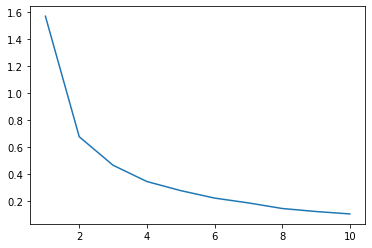

In [37]:
# Train the model
total_step = len(dataloader)
loss_vals=  []
for epoch in range(num_epochs):
    epoch_loss= []
    for i_batch, sample_batched in enumerate(dataloader):
        
        images=sample_batched['image'];
        labels=sample_batched['labels']
        images = images.unsqueeze(1)
        images = images.type(torch.FloatTensor)
      
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
                    
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        epoch_loss.append(loss.item())
        
        optimizer.step()
        
        
        if (i_batch+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i_batch+1, total_step, loss.item()))
            print(loss)
            
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    
my_plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)

In [38]:
test_dataset = GetDataset(csv_file='arabic_letters/csvTestLabel 3360x1.csv',
                                           root_dir='arabic_letters/Test Images 3360x32x32/test',
                                           transform=transforms.Compose([
                                              
                                               ToTensor()
                                           ]))

test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [39]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, sample_batched in enumerate(dataloader):
        
        images=sample_batched['image'];
        labels=sample_batched['labels']
        images = images.unsqueeze(1)
        images = images.type(torch.FloatTensor)
        
        images = images.to(device)
        labels = labels.to(device)
        
        
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        
        labels= torch.reshape(labels, (-1,))
        labels = labels.to(dtype=torch.float32) 
        labels=labels.type(torch.LongTensor)
        
        
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 3360 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 3360 test images: 97.57422427263933 %


In [40]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')
